With Constant Step Size
MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.01

Running  200000 iterations

The Policy is (state,action) = target probability    behavior probability
(0,0) = 0.4835164835164835      0.4351851851851852  (0,1) = 0.5164835164835165      0.5648148148148148  
(1,0) = 0.48854961832061067      0.423728813559322  (1,1) = 0.5114503816793893      0.576271186440678  
(2,0) = 0.881578947368421      0.5714285714285714  (2,1) = 0.11842105263157894      0.42857142857142855  
(3,0) = 0.7980769230769231      0.1  (3,1) = 0.20192307692307693      0.9  
(4,0) = 0.2926829268292683      0.49382716049382713  (4,1) = 0.7073170731707317      0.5061728395061729  
(5,0) = 0.4430379746835443      0.2824427480916031  (5,1) = 0.5569620253164557      0.7175572519083969  
(6,0) = 0.88      0.42168674698795183  (6,1) = 0.12      0.5783132530120482  
(7,0) = 0.4715447154471545      0.1  (7,1) = 0.5284552845528455      0.9  
(8,0) = 0.30952380952380953  

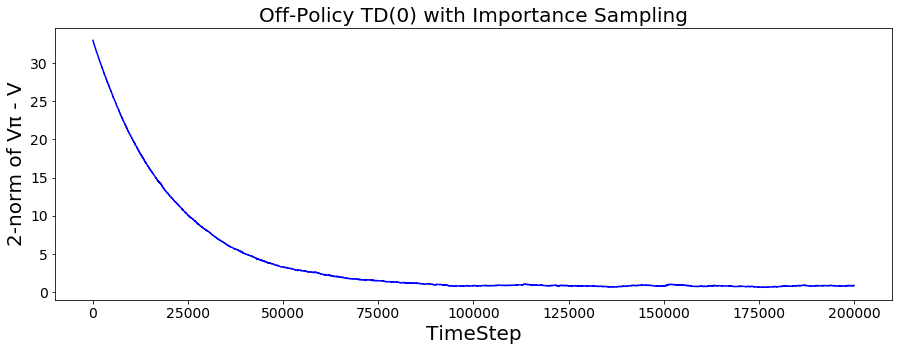

Value Function:   [10.19068465  9.96135249 10.41414323 10.10059302 10.29785812 10.18696311
 10.27013314 10.06860228 10.14026337 10.00296282]

Minimum Delta:   0.6131529487351113
explored states:  defaultdict(<class 'int'>, {2: 20720, 7: 45547, 4: 34758, 0: 15847, 6: 30225, 8: 11433, 9: 13370, 3: 10278, 1: 8275, 5: 9547})



With Diminishing Step Size
MDP with 10 states and 2 actions
discounting factor gamma = 0.95, step size alpha = 0.000995037190209989

Running  500000 iterations

The Policy is (state,action) = target probability    behavior probability
(0,0) = 0.4835164835164835      0.4351851851851852  (0,1) = 0.5164835164835165      0.5648148148148148  
(1,0) = 0.48854961832061067      0.423728813559322  (1,1) = 0.5114503816793893      0.576271186440678  
(2,0) = 0.881578947368421      0.5714285714285714  (2,1) = 0.11842105263157894      0.42857142857142855  
(3,0) = 0.7980769230769231      0.1  (3,1) = 0.20192307692307693      0.9  
(4,0) = 0.2926829268292683      0.49382716049382

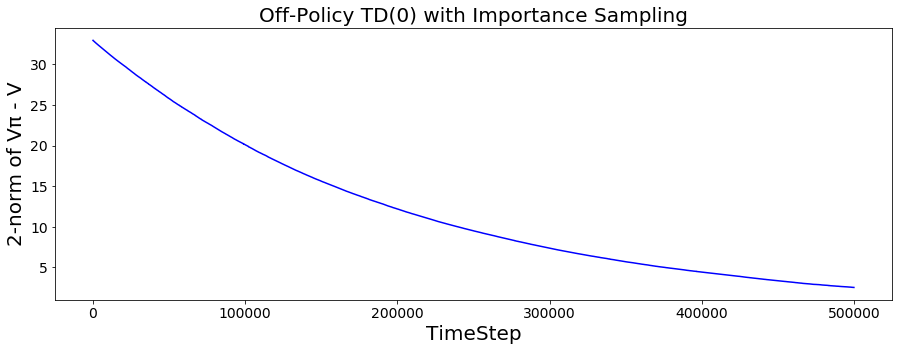

Value Function:   [9.74486176 9.67554215 9.6951613  9.48421763 9.68874672 9.81165634
 9.64703246 9.42775479 9.61941222 9.57283592]

Minimum Delta:   2.5342332916606383
explored states:  defaultdict(<class 'int'>, {0: 25204, 3: 22977, 4: 66541, 5: 114865, 9: 49484, 6: 22677, 2: 103115, 1: 23412, 7: 38553, 8: 33172})


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import mdptoolbox.example
import random


class OffPolicyTDLearner:
    """
    Class that will ues on policy temporal difference
    prediction to solve the model free problem with a given policy

    """

    def __init__(self, target_policy, behavior_policy, states, actions, alpha=0.01, gamma=0.95, beta = 0.5, diminish = None, iterations=100000):
        #action value function, mapping each state action pair
        #initialized to have 0 for every new state action pair
        self.value_function = np.zeros(states)

        #step size between [0,1]
        self.alpha = alpha
        self.gamma = gamma

        #the mapping of states to actions
        self.target_policy = target_policy
        self.behavior_policy = behavior_policy

        #amount of states and actions in the MDP
        self.states = states
        self.actions = actions
        
        #state space S
        self.state_space = np.arange(0,self.states)
        
        #action space A
        self.action_space = np.arange(0,self.actions)

        #transition probability matrix P, with shape AxSxS'
        self.transitionProbabilities, self.rewardMatrix = mdptoolbox.example.rand(states,actions)
        
        #the reward matrix
        self.rewardMatrix = np.random.rand(actions,states,states)

        #transition probability matrix under policy pi
        self.probabilityMatrix = np.zeros((self.states,self.states))
        
        
        #for diminishing step only based on alpha and beta
        self.diminish = diminish
        self.step_size = self.alpha
        self.beta = beta
        
        #keeps track of the amount of times the states have been visited
        self.exploringStates = defaultdict(int)
        
        #estimated v_pi, using value iteration
        self.v_pi = [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]
        
        #save the difference between v_pi and v
        self.norm_difference= []
        
        #amount of iterations to run the environment for
        self.iterations = iterations
    
        
    
    
    def setVpi(self,v_pi):
        """
        Set the estimated v_pi to what you found
        Must be called before running the environment
        Default reward matrix is set to what was found in value iteration
        
        For this to work
        :param v_pi: estimated v_pi, needs to be in length of state space S
        :returns: void
        """
        self.v_pi = v_pi  
        
    
    def setRewardMatrix(self,matrix):
        """
        Change the reward matrix to whatever you want with this function
        Must be called before running the environment
        Default reward matrix is set to random values between [0,1]
        
        For this to work
        Matrix needs to be in shape AxSxS
        A is the Action space
        S is the State space
        
        :param matrix: the reward matrix of choice
        :return: void
        """
        self.rewardMatrix = matrix
        
    def createProbabilityMatrix(self):
        
        #to run TD, the transition probability matrix has to be under the policy 
        #taking the sum of the probabilities of taking that action a under state s and multiplying that by the transition probability value
        
        for s in range(self.states):
            probabilities = np.zeros(self.states)
            for a in range(self.actions):
                    action_prob = self.behavior_policy[s][a]
                    probabilities += self.transitionProbabilities[a][s]*action_prob
            self.probabilityMatrix[s] = probabilities
            

    def getNextState(self, state, action):
        """
        Just return the next state based on the transition probability matrix and the action taken
        Using random choice that will use a distribution to give a state
        :param state: observation that was previously seen
        :param action: action that was take
        :return: next state that the agent will go to 
        """
            
        next_state = np.random.choice(np.arange(0,self.states),1,p = self.probabilityMatrix[state])
        return next_state[0]


    def getValue(self,state):
        """
        Just return the value of the state action pair given the current estimate of the environment
        :param state: observation that was previously seen
        :param action: action that was take
        :return: the value of that state action pair
        """

        return self.value_function[state]
    
    def getImportanceRatio(self,state,action):
        """
        ρt:t_n-1 = from k=t to min(h,T −1) pi [π(Ak|Sk)/b(Ak|Sk)]
        
        only one step so n = 1
        """
        
        rho = self.target_policy[state][action]/self.behavior_policy[state][action]
        return rho

    def updateValueFunction(self,state, next_state,reward,action):
        """
        Update the action value function based on the
        :param state: previous state
        :param action: action taken at state
        :param next_state: next state the agent is planning on going ot
        :param next_action: if agent were at next_state the action the agent is planning on taking
        :param reward: the reward it received at state taking action
        :return: void,will change the q_function in the class

        using the on policy temporal difference formula
        next action is chose greedily
        V(s') = V(s) + αρt:t+n−1[Gt:t+n - V(s)]
        """
        ratio = self.getImportanceRatio(state,action)
    
        self.value_function[state] += self.step_size*ratio*(reward + self.gamma*(self.getValue(next_state))-self.getValue(state))

        
    def chooseAction(self, state):
        """
        Using the current state and the given policy find the action  using random choice based on the probabilities
        """
        
        p = []
        for action,prob in sorted(self.behavior_policy[state].items()):
            p.append(prob)
            
        action = np.random.choice(self.action_space, 1, p = p)
        
        return action[0] 



    def takeAction(self,state,action):
        """
        Perform the action on the environment and see the observation
        
        return: next state S' ,reward R
        state sucessor and the reward observed
        """
        next_state = self.getNextState(state,action)
        reward = self.rewardMatrix[action][state][next_state]
        
        return next_state,reward
    
    
    def runEnvironment(self):
        """
        Will run the environment based on the value function update

        :return: difference between v_pi and v updated each iteration

        """
        
        """
        Rough Estimate of the Value Function Limit
        [10.3269891,10.28997413, 10.61215495, 10.47182536, 10.53804012, 10.44741659, 10.58984017, 10.28781177, 10.42280426, 10.27326007]
        """
        
        
        
    
        #create the transition probability matrix given the policy pi
        self.createProbabilityMatrix()
        
        state = np.random.randint(0,self.states)
        difference = np.zeros(self.iterations)
        total_reward = 0

            
            
        for t in range(self.iterations):
        

            #only for diminishing step size
            if self.diminish!=None and self.step_size>=0.001 and t>0:
                self.step_size = self.diminish(self.alpha, t, self.beta)


            #choose the action based on the behavior policy
            action =self.chooseAction(state)


            #take the action a
            next_state, reward = self.takeAction(state, action)
            # update the V function with the new value
            self.updateValueFunction(state,next_state, reward,action)
            
            self.exploringStates[next_state] +=1
            
            #set the next state to the current state
            state = next_state

            #calculate the difference between v_pi and v
            self.norm_difference.append(np.linalg.norm(self.v_pi - self.value_function))
            
        return self.norm_difference
        
    def plot(self):
        
        """
        Will plot the 2-norm difference found and more information on the results
        For debugging purposes
        """
        
        #info on the MDP
        print(f"MDP with {self.states} states and {self.actions} actions\ndiscounting factor gamma = {self.gamma}, step size alpha = {self.step_size}\n")
        print("Running ", self.iterations, "iterations")
        
        #info on the policy
        print("\nThe Policy is (state,action) = target probability    behavior probability")
        for s in range(self.states):
            for a in range(self.actions):
                print(f"({s},{a}) = {self.target_policy[s][a]}      {self.behavior_policy[s][a]} ",end=" ")
            print()
                      
        
        #plot the difference between v-pi and v
        plt.figure(figsize=(15,5))
        plt.plot(range(self.iterations), self.norm_difference, 'b-')
        plt.title("Off-Policy TD(0) with Importance Sampling",fontsize = 20)
        plt.xlabel("TimeStep",fontsize = 20)
        plt.ylabel("2-norm of Vπ - V",fontsize = 20)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)
        plt.show()
        
        #info on the value function
        print("Value Function:  ", self.value_function)
        print("\nMinimum Delta:  ", min(self.norm_difference))
        print("explored states: ", self.exploringStates)


if __name__ == '__main__':
    
    
    """
    The Main Function to Run your program
    Example code given below
    All hyperparameters can be adjusted to your liking
    
    
    Policy must be given  
    the policy will be in the format of 
    (state,action) = Probability
    
    in python code it will be a dictionary inside of a dictionary
    {state: {action: probability of that action, action: probabiity, ... } state:{...}}
    """

    
    
    target_policy = {0: {0: 0.4835164835164835, 1: 0.5164835164835165}, 1: {0: 0.48854961832061067, 1: 0.5114503816793893}, 2: {0: 0.881578947368421, 1: 0.11842105263157894}, 3: {0: 0.7980769230769231, 1: 0.20192307692307693}, 4: {0: 0.2926829268292683, 1: 0.7073170731707317}, 5: {0: 0.4430379746835443, 1: 0.5569620253164557}, 6: {0: 0.88, 1: 0.12}, 7: {0: 0.4715447154471545, 1: 0.5284552845528455}, 8: {0: 0.30952380952380953, 1: 0.6904761904761905}, 9: {0: 0.34328358208955223, 1: 0.6567164179104478}}
    behavior_policy = {0: {0: 0.4351851851851852, 1: 0.5648148148148148}, 1: {0: 0.423728813559322, 1: 0.576271186440678}, 2: {0: 0.5714285714285714, 1: 0.42857142857142855}, 3: {0: 0.1, 1: 0.9}, 4: {0: 0.49382716049382713, 1: 0.5061728395061729}, 5: {0: 0.2824427480916031, 1: 0.7175572519083969}, 6: {0: 0.42168674698795183, 1: 0.5783132530120482}, 7: {0: 0.1, 1: 0.9}, 8: {0: 0.8636363636363636, 1: 0.13636363636363635}, 9: {0: 0.3401360544217687, 1: 0.6598639455782312}}
    
    states = 10
    actions = 2
    iterations = 200000
    
    np.random.seed(0)

    print("With Constant Step Size")
    learner = OffPolicyTDLearner(target_policy= target_policy,behavior_policy = behavior_policy,states = states, actions = actions,iterations = iterations)
    learner.runEnvironment()
    learner.plot()
    
    
    print("\n\n\nWith Diminishing Step Size")
    learner = OffPolicyTDLearner(target_policy= target_policy,behavior_policy = behavior_policy,states = states, actions = actions,iterations =500000 , diminish = lambda a,k,b: a/(k**b))
    learner.runEnvironment()
    learner.plot()


